### Ways Kmeans fails
There are many instances where kmeans does not perform well that our algorithm hopefully can work better because of not using the euclidean distance metric. In this document we'll show the kinds of datasets for which kmeans gives out nonsensical communities, and show that altmeans helps in those situations (:fingerscrossed:)

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression 

import sys
sys.path.append("/nobackup/gogandhi/alt_means_sans_k/")
from scripts.similarity_scores import louvain, calc_esim,find_knn_edges



def alt_means_ootb(emb, communities, device_name="cuda:0", num_neighbors=100): 
    # Here emb is just an array of datapoints, where each row corresponds to a d dimensional array corresponding to a point.
    # Community table is an array with community partitions, which will be converted 
    # below into a pandas dataframe, with 'community_id' column containing the array data.

    

    # Normalize the vector of each node to have unit length. This normalization improves clustering.
    X = np.einsum("ij,i->ij", emb, 1 / np.maximum(np.linalg.norm(emb, axis=1), 1e-24))
    X = emb.copy()
    # Clustering


    rpos, cpos, vpos = find_knn_edges(emb, num_neighbors=num_neighbors, device = device_name)
    cneg = np.random.choice(emb.shape[0], len(cpos))
    vneg = np.array(np.sum(emb[rpos, :] * emb[cneg, :], axis=1)).reshape(-1)

    model = LogisticRegression()
    model.fit(
        np.concatenate([vpos, vneg]).reshape((-1, 1)),
        np.concatenate([np.ones_like(vpos), np.zeros_like(vneg)]),
            )
    w1, b0 = model.coef_[0, 0], -model.intercept_[0] 

    kmeans = KMeans(n_clusters= len(set(communities)), random_state=0).fit(X)
    kmeans_esim = calc_esim(communities, kmeans.labels_)
    
    
    proposed_labels = louvain(emb, w1, b0, device = device_name)
    esim = calc_esim(communities, proposed_labels) 
        
    
    return proposed_labels, kmeans.labels_, esim, kmeans_esim 

## Issue 1 
By use of the Euclidean distance K-means treats the data space as isotropic (distances unchanged by translations and rotations). This means that data points in each cluster are modeled as lying within a sphere around the cluster centroid. A sphere has the same radius in each dimension. Furthermore, as clusters are modeled only by the position of their centroids, K-means implicitly assumes all clusters have the same radius. When this implicit equal-radius, spherical assumption is violated, K-means can behave in a non-intuitive way, even when clusters are very clearly identifiable by eye.

/nobackup/gogandhi/miniconda3/envs/kmeans_env/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/nobackup/gogandhi/miniconda3/envs/kmeans_env/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


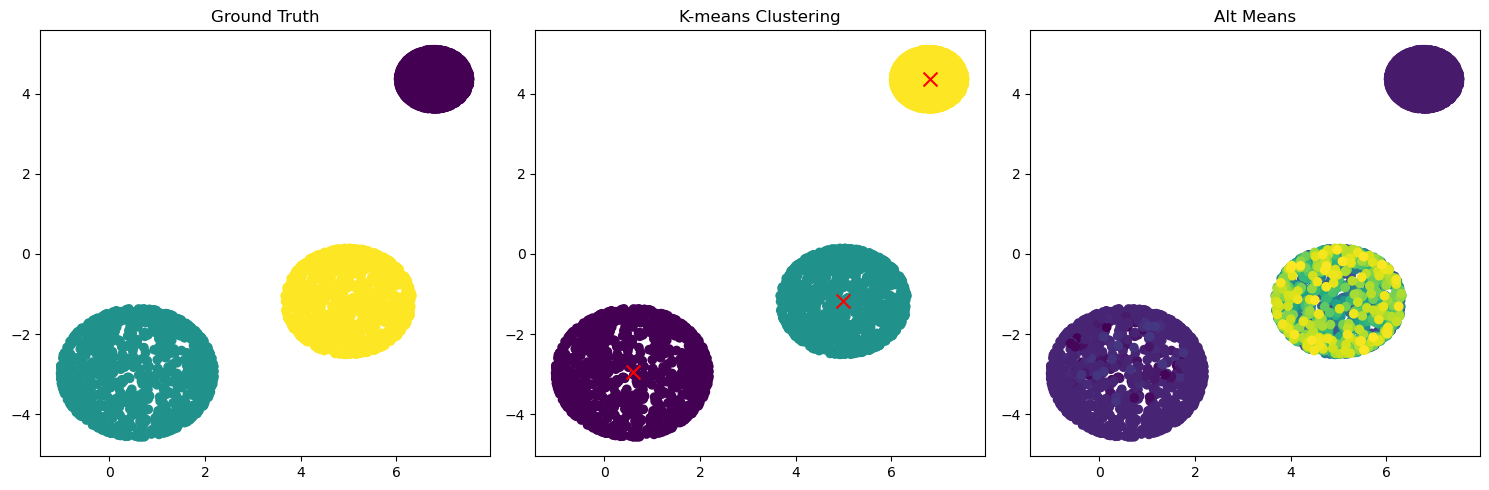

In [8]:
num_points_per_cluster = 1000
num_clusters = 3
total_points= int(num_points_per_cluster*num_clusters)
dimension = 2
num_neighbors = 5

variance = 3.0  # Known variance
radii = [3.5, 6, 1]  # Different radii for each cluster
origins = [[-4, -4, 5], [5, 5, 5], [0, 0, 0]]  # Different origins for each cluster


import numpy as np

def generate_data(num_points, num_clusters, variance=1.0, radii=None, origins=None):
    #np.random.seed(42)
    data = []
    if radii is None:
        radii = np.random.uniform(0.5, 2.0, num_clusters)  # Random radii for each cluster
    if origins is None:
        origins = np.random.uniform(-10, 10, (num_clusters, 3))  # Random origins for each cluster
    
    for i in range(num_clusters):
        radius = radii[i]
        origin = origins[i]
        points = np.random.randn(num_points//num_clusters, 3) * np.sqrt(variance)  # Spherical normal data
        points /= np.linalg.norm(points, axis=1)[:, np.newaxis]  # Project points to the unit sphere
        points *= radius  # Scale points to match the radius
        points += origin  # Translate points to match the origin
        data.append(points)
    return np.vstack(data)

data = generate_data(total_points, num_clusters, variance, None, None)


ground_truth_labels = np.repeat(np.arange(num_clusters), num_points_per_cluster)

# K-means plot

kmeans = KMeans(n_clusters=num_clusters, random_state=42)
kmeans_labels = kmeans.fit_predict(data)

alt_means_labels, kmeans_labels, esim, kmeans_esim  = alt_means_ootb(data, ground_truth_labels, "cuda:0", num_neighbors)

# Plotting
plt.figure(figsize=(15, 5))

# Ground truth plot
plt.subplot(1, 3, 1)
plt.scatter(data[:, 0], data[:, 1], c=ground_truth_labels, cmap='viridis')
plt.title('Ground Truth')


plt.subplot(1, 3, 2)
plt.scatter(data[:, 0], data[:, 1], c=kmeans_labels, cmap='viridis')
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], marker='x', s=100, c='red')
plt.title('K-means Clustering')

# Alternative means plot
plt.subplot(1, 3, 3)
plt.scatter(data[:, 0], data[:, 1], c=alt_means_labels, cmap='viridis')
plt.title('Alt Means')

plt.tight_layout()
plt.show()

# Issue 2
Spherical communities that don't intersect and have different radii originating from the same point.

Result: Kmeans can't figure it out, but alt_means can't as well

/nobackup/gogandhi/miniconda3/envs/kmeans_env/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/nobackup/gogandhi/miniconda3/envs/kmeans_env/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


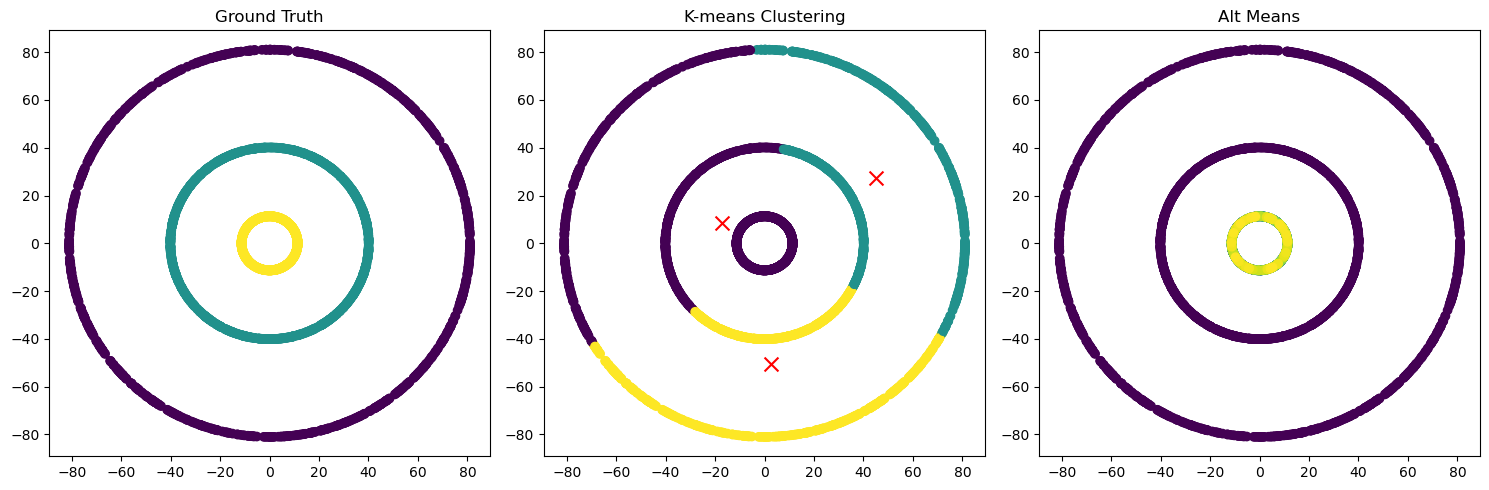

In [23]:
def generate_data(num_points, num_clusters, d=2):
    #np.random.seed(42)
    data = []
    for i in range(num_clusters):
        radius = np.random.uniform(0.5, 100.0)  # Random radius for each cluster
        points = np.random.randn(num_points//num_clusters, d)
        points /= np.linalg.norm(points, axis=1)[:, np.newaxis]  # Project points to the unit sphere
        points *= radius  # Scale points to match the radius
        data.append(points)

    return np.vstack(data)
    
    
    
    
num_points_per_cluster = 1000
num_clusters = 3
total_points= int(num_points_per_cluster*num_clusters)
dimension = 2
num_neighbors = 100

data = generate_data(total_points, num_clusters, dimension)

ground_truth_labels = np.repeat(np.arange(num_clusters), num_points_per_cluster)

# K-means plot

kmeans = KMeans(n_clusters=num_clusters, random_state=42)
kmeans_labels = kmeans.fit_predict(data)

alt_means_labels, kmeans_labels, esim, kmeans_esim  = alt_means_ootb(data, ground_truth_labels, "cuda:0", num_neighbors)

# Plotting
plt.figure(figsize=(15, 5))

# Ground truth plot
plt.subplot(1, 3, 1)
plt.scatter(data[:, 0], data[:, 1], c=ground_truth_labels, cmap='viridis')
plt.title('Ground Truth')


plt.subplot(1, 3, 2)
plt.scatter(data[:, 0], data[:, 1], c=kmeans_labels, cmap='viridis')
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], marker='x', s=100, c='red')
plt.title('K-means Clustering')

# Alternative means plot
plt.subplot(1, 3, 3)
plt.scatter(data[:, 0], data[:, 1], c=alt_means_labels, cmap='viridis')
plt.title('Alt Means')

plt.tight_layout()
plt.show()